In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

In [2]:
def get_image_files(directory):
    image_files = []
    for file in os.listdir(directory):
        if file.endswith(".pgm"):
            image_files.append(os.path.join(directory, file))
    return image_files

In [3]:


path = './database'
images = get_image_files(path)
gt_images = [i for i in images if 'gt' in i]


print(gt_images)

['./database\\10_gt.pgm', './database\\11_gt.pgm', './database\\12_gt.pgm', './database\\13_gt.pgm', './database\\14_gt.pgm', './database\\15_gt.pgm', './database\\16_gt.pgm', './database\\17_gt.pgm', './database\\18_gt.pgm', './database\\19_gt.pgm', './database\\1_gt.pgm', './database\\20_gt.pgm', './database\\2_gt.pgm', './database\\3_gt.pgm', './database\\4_gt.pgm', './database\\5_gt.pgm', './database\\6_gt.pgm', './database\\7_gt.pgm', './database\\8_gt.pgm', './database\\9_gt.pgm']


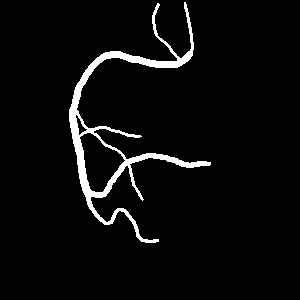

In [4]:

# Load an image
image = cv2.imread(gt_images[10])

Image.fromarray(image)


In [5]:
def skeletonizeMorphological(img):
    img = cv2.imread(img,0)
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)

    ret,img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    #Obtained from: https://opencvpython.blogspot.com/2012/05/skeletonization-using-opencv-python.html
    #Skeleton = I - HitOrMiss(I, J)
        #https://homepages.inf.ed.ac.uk/rbf/HIPR2/thin.htm
    while( not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True
    
    return skel

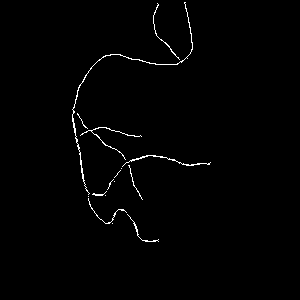

In [6]:

skel = skeletonizeMorphological(gt_images[10])
Image.fromarray(skel)


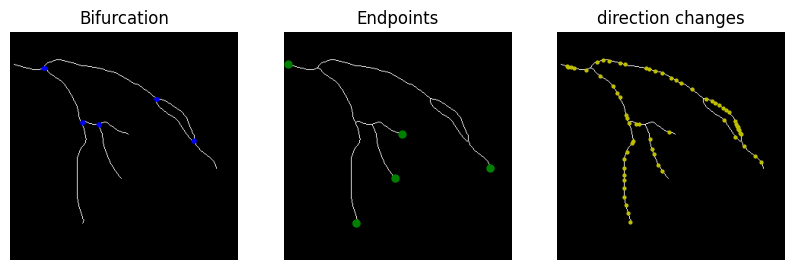

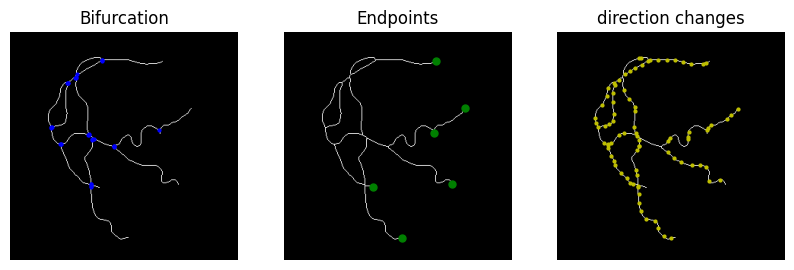

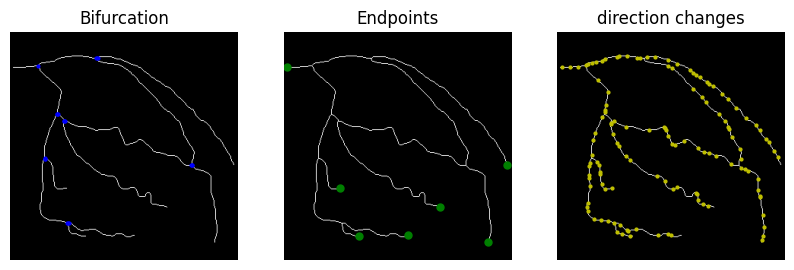

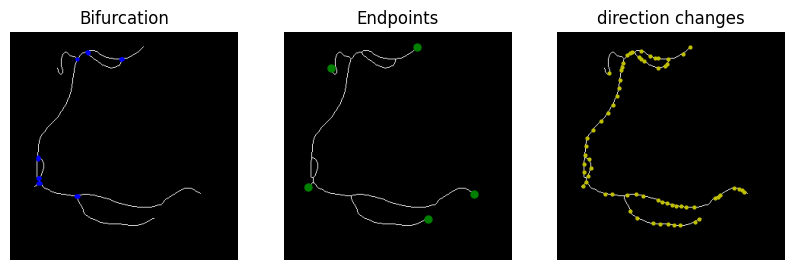

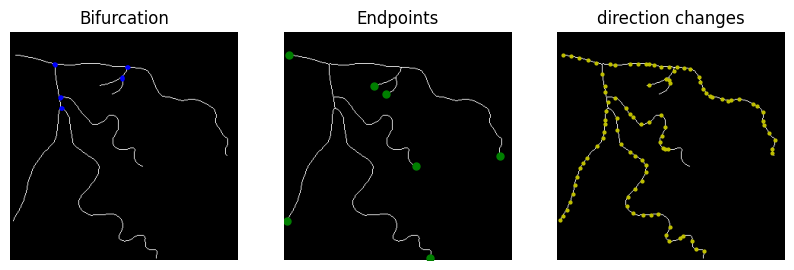

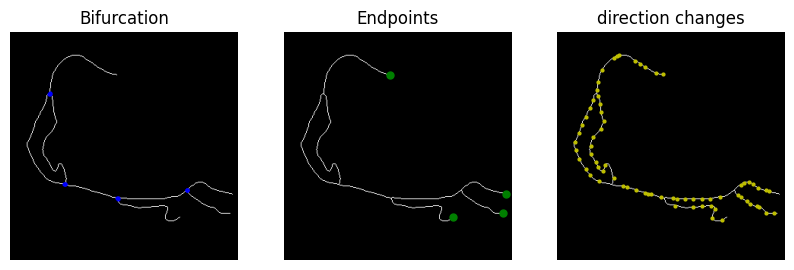

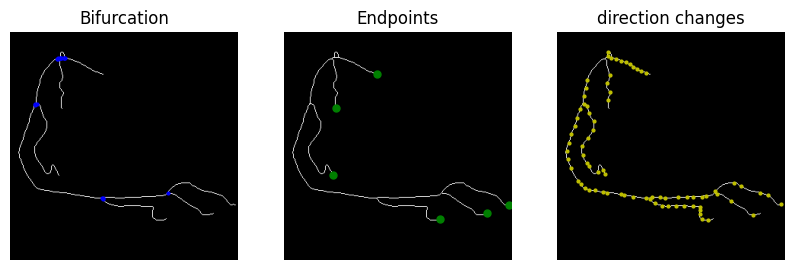

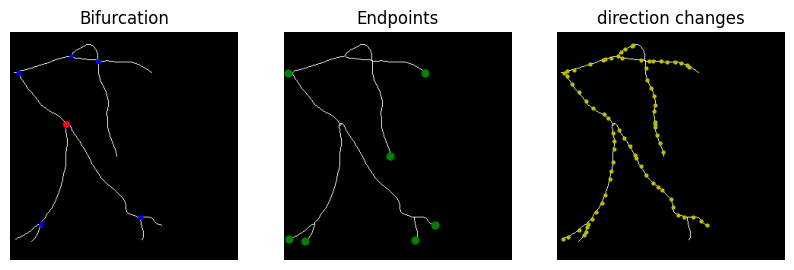

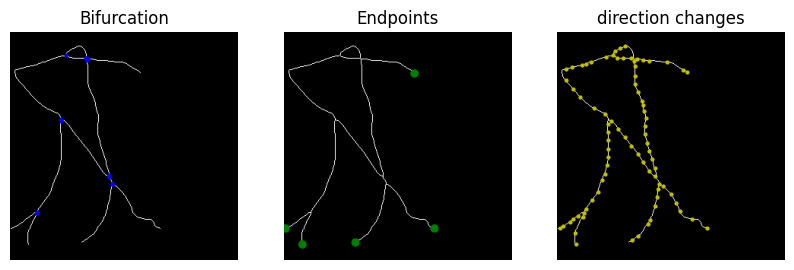

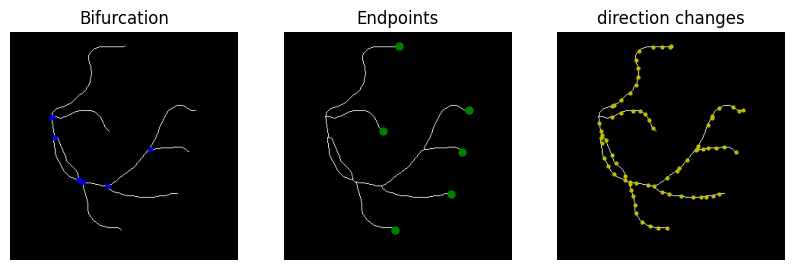

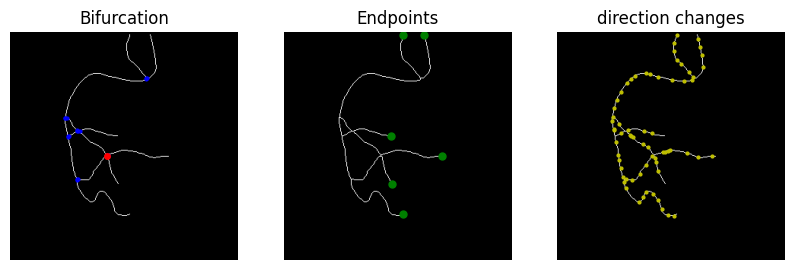

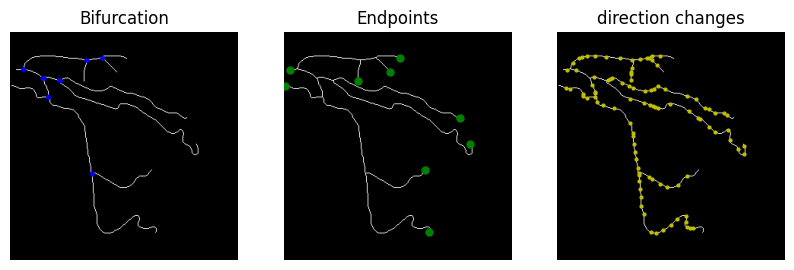

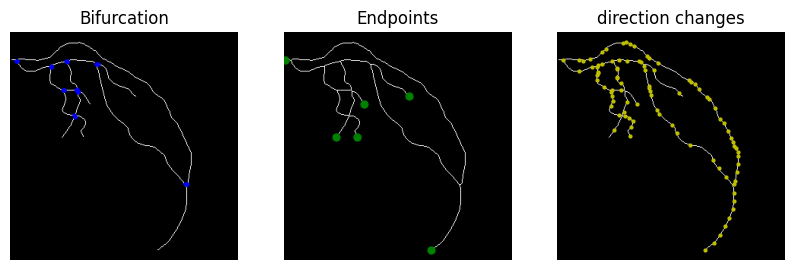

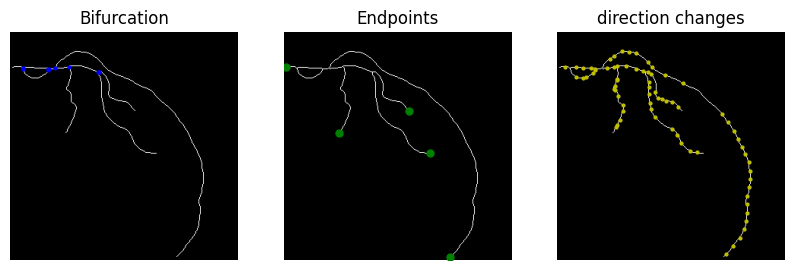

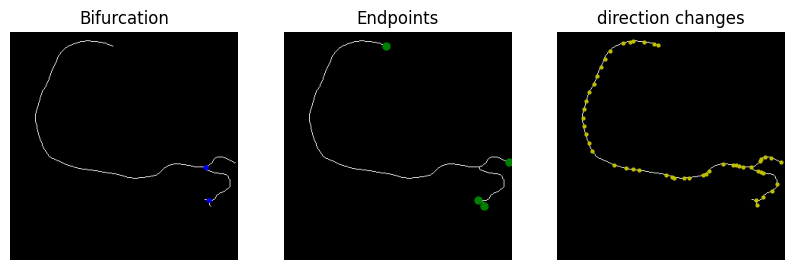

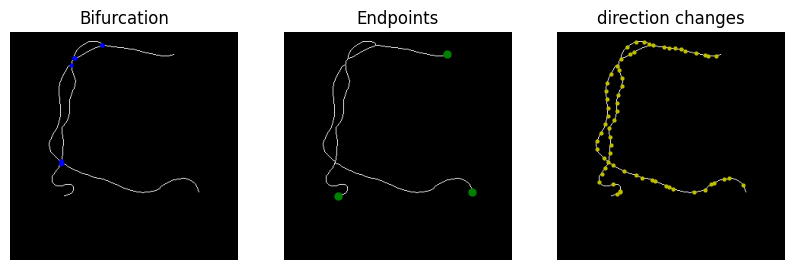

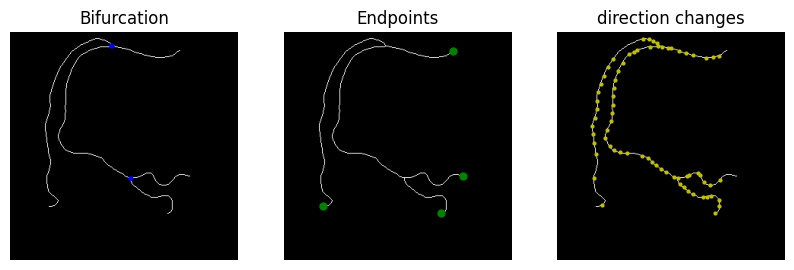

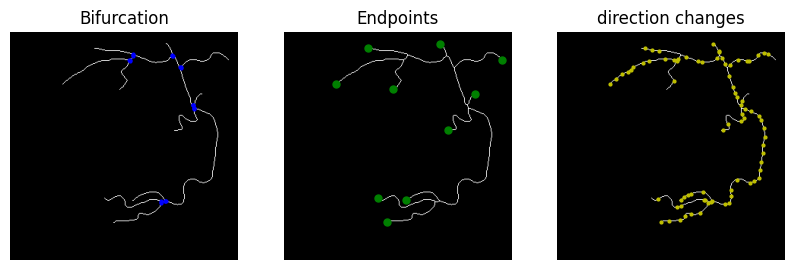

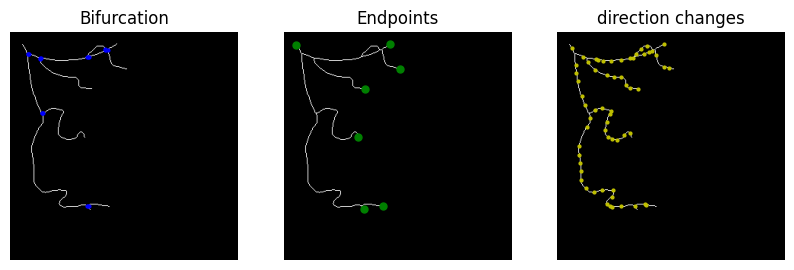

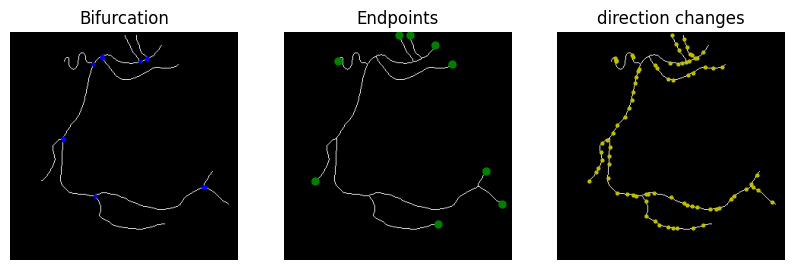

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from skimage.morphology import skeletonize
from scipy.ndimage import convolve
from skimage import io

def memes(pimage, data):

    def skeletonize2(image_path):
        image = cv2.imread(image_path, 0)
        binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)[1]
        skeleton = skeletonize(binary_image // 255) * 255
        return skeleton.astype(np.uint8)

    def find_bifurcation(skeleton):
        kernel = np.array([[1, 1, 1],
                        [1, 10, 1],
                        [1, 1, 1]], dtype=np.uint8)
        
        conv_image = convolve(skeleton // 255, kernel)
        
        bifurcation = (conv_image == 13) * 255
        return bifurcation.astype(np.uint8)

    def find_trifurcation(skeleton):
        kernel = np.array([[1, 1, 1],
                        [1, 10, 1],
                        [1, 1, 1]], dtype=np.uint8)
        
        conv_image = convolve(skeleton // 255, kernel)
        
        trifurcation = (conv_image == 15) * 255
        return trifurcation.astype(np.uint8)

    def find_endpoints(skeleton):
        kernel = np.array([[1, 1, 1],
                        [1, 10, 1],
                        [1, 1, 1]], dtype=np.uint8)

        conv_image = convolve(skeleton // 255, kernel)
        
        endpoints = (conv_image == 11) * 255
        return endpoints.astype(np.uint8)
    
    def detect_direction_changes(skeleton):
        direction_changes = []
        counter = 0
        for i in range(1, skeleton.shape[0] - 1):
            for j in range(1, skeleton.shape[1] - 1):
                if skeleton[i, j] == 255:
                    window = skeleton[i - 1:i + 2, j - 1:j + 2]
                    if window.sum() >= 255:
                        if counter == 0:
                            direction_changes.append((i, j))
                            counter += 10
                        else:
                            counter -= 1

        return direction_changes

    skeleton = skeletonize2(pimage)
    bifurcation = find_bifurcation(skeleton)
    trifurcation = find_trifurcation(skeleton)
    endpoints = find_endpoints(skeleton)
    directionpoints = detect_direction_changes(skeleton)

    data[pimage]["bifurcation"] = []
    data[pimage]["trifurcation"] = []
    data[pimage]["endpoints"] = []
    data[pimage]["intermediaries"] = []
    
    

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(skeleton, cmap='gray')
    plt.title('Bifurcation')
    plt.axis('off')

    bifurcation_coords = np.argwhere(bifurcation == 255)
    for coord in bifurcation_coords:
        data[pimage]["bifurcation"].append([int(coord[0]), int(coord[1])])
        plt.plot(coord[1], coord[0], 'bo', markersize=2)

    trifurcation_coords = np.argwhere(trifurcation == 255)
    for coord in trifurcation_coords:
        data[pimage]["trifurcation"].append([int(coord[0]), int(coord[1])])
        plt.plot(coord[1], coord[0], 'ro', markersize=4)

    plt.subplot(1, 3, 2)
    plt.imshow(skeleton, cmap='gray')
    plt.title('Endpoints')
    plt.axis('off')

    endpoints_coords = np.argwhere(endpoints == 255)
    for coord in endpoints_coords:
        data[pimage]["endpoints"].append([int(coord[0]), int(coord[1])])
        plt.plot(coord[1], coord[0], 'go', markersize=5)

    plt.subplot(1, 3, 3)
    plt.imshow(skeleton, cmap='gray')
    plt.title('direction changes')
    plt.axis('off')

    direction_changes_coords = np.array(directionpoints)
    for coord in direction_changes_coords:
        data[pimage]["intermediaries"].append([int(coord[0]), int(coord[1])])
        plt.plot(coord[1], coord[0], 'yo', markersize=2)

    plt.show()
        

data = {}

for x in gt_images:
    data[x] = {}
    memes(x, data)


In [15]:

def toJSON(obj):
    with open("datosNodos.json", "w") as json_file:
        json.dump(obj, json_file, indent=4)

toJSON(data[gt_images[0]])